# This is an examples of how to perform a mcmc Voigt profile fit to absorption lines interactively in jupyter notebook


## Written By: Rongmon Bordoloi
----------------

The goal of this notebook is to show a running example of Voigt profile fit to a real HST/COS UV spectrum. 
This example shows you how this complex model can be easily modifed to suit your fitting needs.


-----------------
Example Created: Feb 10, 2021

Tested on Python 3.7

-------------------
## Requirements: 

astropy, numpy, scipy, matplotlib,linetools, emcee and corner



linetools for input output of fits files, and for COS LSF

Required emcee and corner

https://emcee.readthedocs.io/en/stable/
https://corner.readthedocs.io/en/latest/

In [25]:
#Load modules
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
from importlib import reload
from rbvfit import guess_profile_parameters_interactive as g
from linetools.spectra.xspectrum1d import XSpectrum1D  
from rbvfit import vfit_mcmc as mc
from rbvfit import model as m
reload(m)
reload(mc)


<module 'rbvfit.vfit_mcmc' from '/Users/bordoloi/WORK/python/rbvfit/src/rbvfit/vfit_mcmc.py'>

## Read in the data that you want to fit and prepare data 

In [3]:
#Change this to the continuum normalized spectrum you are using for the fit
filename='/Users/bordoloi/Dropbox/COS-Pairs/Targets/J2228-0950/Data/J2228-0950_nbin3_coadd_wc.fits'
sp=XSpectrum1D.from_file(filename)

## Show what we are using to perform a fit here. This is an actual HST/COS spectrum
 The red line is a continuum fit performed on the spectrum

<IPython.core.display.Javascript object>


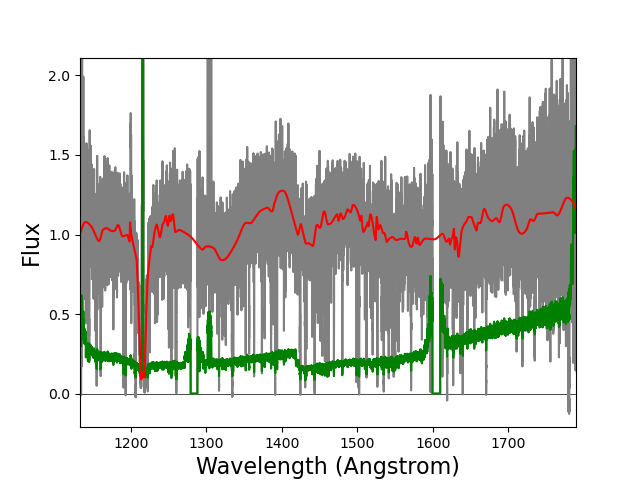

In [4]:
sp.plot()

## Preprocessing >
 Create small slices of the spectrum which will be locally fitted. For this example we will show several HI transitions that will be simultaneously fitted. You can do this step somewhere else, and read in the ready to fit small slices of spectrum.

In [5]:
#Redshift of the absorber you are trying to fit
zabs=0.464854

#Normalizing the spectrum
wave_full=sp.wavelength.value
flux=sp.flux.value/sp.co.value
error=sp.sig.value/sp.co.value



#Making slices in obsered frame and selecting around two HI lines (1215,1025)
q=np.where(((wave_full/(1.+zabs) >1022.) & (wave_full/(1.+zabs) < 1028.)) | ((wave_full/(1.+zabs) >1210.) & (wave_full/(1.+zabs) < 1220.))
          | ((wave_full/(1.+zabs) >969.) & (wave_full/(1.+zabs) < 975.)))

#q=np.where(((wave_full/(1.+zabs) >969.) & (wave_full/(1.+zabs) < 975.)))

#Up to this part, and the previous cell, you can replace wiht your own code to read spectra 
#---------------------------------

# The wave,normalzied flux, normalized error arrays used for the fitting process

wave=wave_full[q]
flux=flux[q]
error=error[q]


# ***********************************************
# Important Model Definition part
## Start preparing the model for fitting interactively

This is the most important part of the fitting process. You have to carefully set up the model so that it does what you think it is doing.

<IPython.core.display.Javascript object>


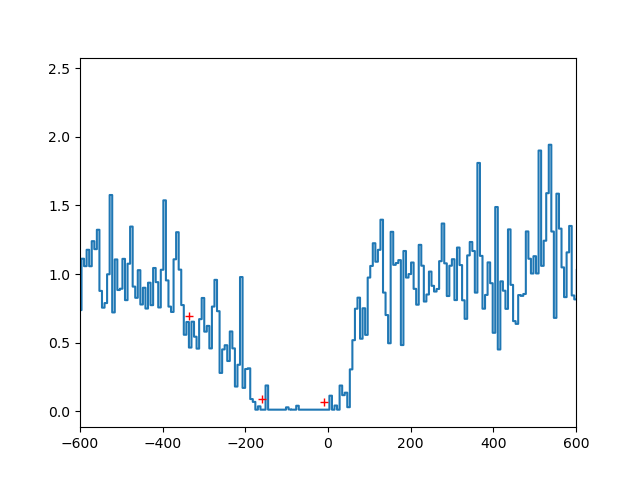

HTML(value='')

In [22]:
#-------------------------------------------------------------
# This is the part you want to edit to define your model
    
# . With default 6.5 pixel FWHM of HST/COS and Gaussian convolution

#Input how many redshifts you are fitting in this process.
# Absorber redshift to fit
zabs=np.array([0.464854])



#Which transitions to fit
lambda_rest = [1215.67,1025.6,972.5368]# * np.ones((len(zabs),))
reload(g)
tab=g.gui_set_clump(wave,flux,error,zabs[0],lambda_rest[0],xmin=[-800.,800.])


# Interactively guess b values for each cloud selected

In [23]:
tab.b_guess()

Guess  b  for line 1/3, vel guess = 0.0, col guess= 13.9: 30
Guess  b  for line 2/3, vel guess = 0.0, col guess= 13.9: 35
Guess  b  for line 3/3, vel guess = 0.0, col guess= 13.9: 40


## Book keeping to organize everything so that we can do model fitting

In [19]:
nguess=tab.nguess
bguess=tab.bguess
vguess=tab.vguess

#Setting the upper and lower limits for the fit. You can also do it by hand if you prefer
bounds,lb,ub=mc.set_bounds(nguess,bguess,vguess)


#------------------------------------------------------

# Doing some book keeping to organize the guess
theta=np.concatenate((nguess,bguess,vguess))



#More book keeping
#No of clouds in the fit 
nclump= len(nguess)
#No of transitions going into the fit
ntransition=len(lambda_rest)


zabs

array([0.464854])

# Prepare Model to Fit

In [20]:


#------------------------------------------------------



print('Preparing model to fit **********')

# I am using a default Gaussian FWHM of 6.5 pixels for HST/COS data, you can replace this with grating, and lifetime information to use the exact HST/COS LSF

s=m.create_voigt(zabs,lambda_rest,nclump,ntransition=ntransition,FWHM = '6.5')#, grating='G130M',life_position='2')


y=s.model_flux(theta,wave)
print(' Done Preparing Model ************')

Preparing model to fit **********
 Done Preparing Model ************


## Quick view, how the model looks

<IPython.core.display.Javascript object>


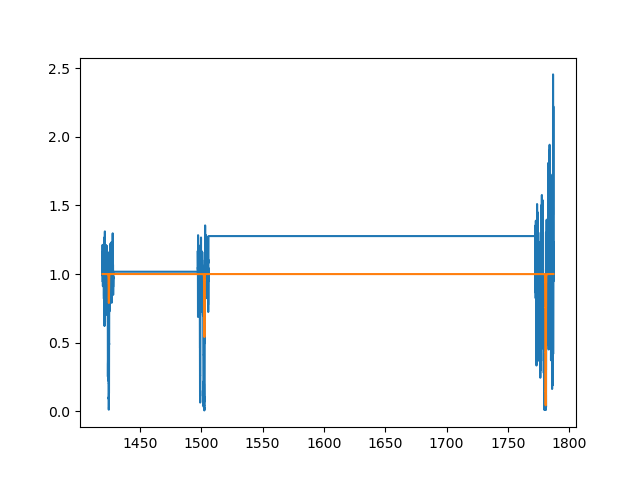

In [21]:

plt.step(wave,flux)
plt.step(wave,y)

## Now run mcmc fitting

In [15]:
t = mc.vfit(s.model_flux, theta, lb, ub, wave, flux, error)
t.runmcmc()


Optimizing Guess ***********


/Users/bordoloi/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/bordoloi/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/bordoloi/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Done ***********
Preparing emcee ***********
Starting emcee ***********


/Users/bordoloi/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/bordoloi/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Start Burntime Calculations ***********
Done Burning Steps!
Now starting the Final Calculations:
*****************
[##############################]


## Show the posterior distribution of the fitted paramters


In [16]:
t.plot_corner()

<IPython.core.display.Javascript object>

## Extract the best fit paramters 

In [17]:
theta_prime=t.best_theta # Best Fit
theta_low=t.low_theta # lower bound
theta_high=t.high_theta # Upper bound

sample_full= t.samples  # Full Matrix containing the posterior distribution functions


## Plot the model fits

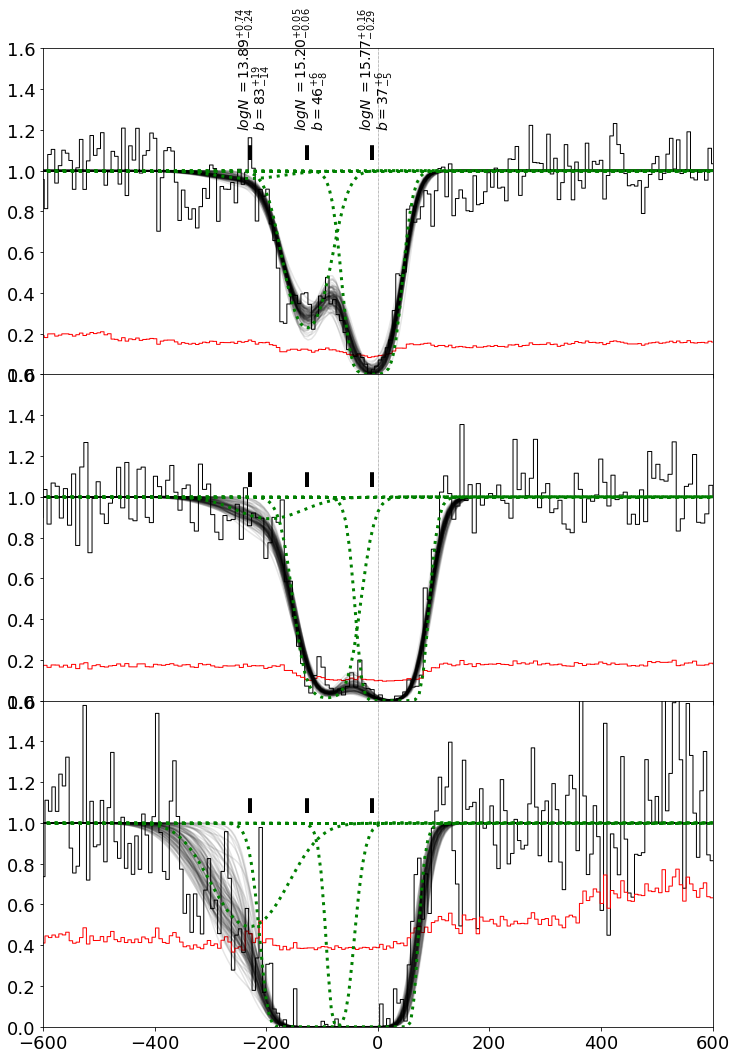

In [22]:
reload(mc)
%matplotlib inline
mc.plot_model(wave,flux,error,t,s)

# Save Final fitted paramters.

## The best fit paramters are saved in a dictionary. These are then saved in the binary pickle format. You can change it to your favourite format (e.g. fits, hdf5, json).


In [21]:
outfilename= 'test_fit'


best_N=theta_prime[0:nclump]
best_b=theta_prime[nclump:2*nclump]
best_v=theta_prime[2*nclump:3*nclump]

low_N=theta_low[0:nclump]
low_b=theta_low[nclump:2*nclump]
low_v=theta_low[2*nclump:3*nclump]

high_N=theta_high[0:nclump]
high_b=theta_high[nclump:2*nclump]
high_v=theta_high[2*nclump:3*nclump]


t['best_N']=best_N
t['best_b']=best_b
t['best_v']=best_v
t['low_N']=low_N
t['low_b']=low_b
t['low_v']=low_v
t['high_N']=high_N
t['high_b']=high_b
t['high_v']=high_v


best_fit1,f11 = t.mod(theta_prime,wave_obs1,line)

t['best_fit']=best_fit1
t['best_ind_fit']=f11

# Now Finally save everything
#with open(outfilename+'_fit.p', 'wb') as handle:
#    pickle.dump(s,handle, pickle.HIGHEST_PROTOCOL)


TypeError: 'create_voigt' object does not support item assignment